In [4]:
import os

from plotlyflask_server.data_parser import sort_RAFT_table as sRt
import pandas as pd
import numpy as np
import plotly.express as px
import re
from scipy.optimize import curve_fit
import itertools
from tqdm import tqdm

C:\Users\fo72qev\PycharmProjects\sort_RAFT_table


In [5]:
# plotly does not work with jupyterlab 7 or higher out of the box (https://github.com/plotly/plotly.py/issues/4336) so the following lines are neccessary:
import plotly.io as pio
pio.renderers.default = 'iframe'
# another fix might be "pip install jupyterlab_mathjax2"

In [6]:
# rectify/balance the table
sRt.df["t6h-conversion"] = np.nan
sRt.df["t10h-conversion"] = np.nan

# get all conversion headers, sort them by the hours
conversion_list = []
for column in sRt.df.columns:
    if "conversion" in column:
        conversion_list.append(column)

conversion_list.sort(key=lambda x: int(re.findall(r"\d+", x)[0]))

# get all the Mn and Mw headers
Mn_list = []
Mw_list = []
for column in sRt.df.columns:
    if "Mn" in column:
        Mn_list.append(column)
    if "Mw" in column:
        Mw_list.append(column)

print(conversion_list, Mn_list, Mw_list, sep="\n")

['t0h-conversion', 't1h-conversion', 't2h-conversion', 't4h-conversion', 't6h-conversion', 't8h-conversion', 't10h-conversion', 't15h-conversion']
['t0h-Mn', 't1h-Mn', 't2h-Mn', 't4h-Mn', 't6h-Mn', 't8h-Mn', 't10h-Mn', 't15h-Mn']
['t0h-Mw', 't1h-Mw', 't2h-Mw', 't4h-Mw', 't6h-Mw', 't8h-Mw', 't10h-Mw', 't15h-Mw']


In [7]:
def change_timeformat(time_format):
    h_m_s = str(time_format).split(":")
    m_format = int(h_m_s[0]) * 60 + int(h_m_s[1]) + int(h_m_s[2]) / 60
    return m_format

def change_timeformat_h(time_format):
    h_m_s = str(time_format).split(":")
    h_format = int(h_m_s[0]) + (int(h_m_s[1]) + int(h_m_s[2]) / 60) /60
    return h_format

# creating a table as a lookup to correct all sample measurement times

# get the hours from the headers with regex
hours_list = []
two_digit_regex = r"\d+"
for column in conversion_list:
    hours_list.append(int(re.findall(two_digit_regex, column)[0]))
hours_list.sort()

exact_times = pd.read_excel(sRt.INPUT_FILE_PATH, sheet_name="exact sampling times")

time_correction_df = pd.DataFrame(data=exact_times.iloc[3:12, 3:])
time_correction_df.columns = exact_times.loc[2][3:]

time_correction_df.reset_index(inplace=True, drop=True)
ext_time_corr_df_data =[]
for row in time_correction_df.iterrows():
    reactor_nr = row[1]["Reactor"]
    if type(reactor_nr) == int or reactor_nr == "closing of reactors": # that applies to reactor 15 and the closing of reactors
        row[1]["Reactor"] = str(reactor_nr)
        ext_time_corr_df_data.append(row[1])
    else: # that applies to all reactors which are described per row in pairs like "3+4"
        reactor_nr_s = (row[1]["Reactor"]).split("+")
        for reactor_nr in reactor_nr_s:
            row[1]["Reactor"] = reactor_nr
            ext_time_corr_df_data.append(row[1].copy())
ext_time_corr_df = pd.DataFrame(data=ext_time_corr_df_data, columns=exact_times.loc[2][3:])
ext_time_corr_df.reset_index(drop=True, inplace=True)
print("The timer was reset to 0 after the first closing of reactors in the \"t = 0\"-sampling-step")
ext_time_corr_df.columns = ["Reactor", 0, 1, 2, 4, 6, 8, 10, 15]

# change time format to minutes and set
time_cols = ext_time_corr_df.columns.difference(["Reactor"])
ext_time_corr_df[time_cols] = ext_time_corr_df[time_cols].apply(lambda x: [change_timeformat_h(d) for d in x])
ext_time_corr_df[0] = ext_time_corr_df[0].apply(lambda x: 0 )

# set index to reactor
ext_time_corr_df.set_index("Reactor", inplace=True)

ext_time_corr_df

The timer was reset to 0 after the first closing of reactors in the "t = 0"-sampling-step


,0,1,2,4,6,8,10,15
Reactor,,,,,,,,
1,0,1.005556,2.011111,4.018056,6.008333,8.016667,10.011111,15.016667
2,0,1.005556,2.011111,4.018056,6.008333,8.016667,10.011111,15.016667
3,0,1.073611,2.068056,4.077778,6.063889,8.090278,10.084722,15.098611
4,0,1.073611,2.068056,4.077778,6.063889,8.090278,10.084722,15.098611
5,0,1.131944,2.125000,4.143056,6.120833,8.180556,10.158333,15.200000
6,0,1.131944,2.125000,4.143056,6.120833,8.180556,10.158333,15.200000
7,0,1.191667,2.184722,4.205556,6.180556,8.256944,10.233333,15.291667
8,0,1.191667,2.184722,4.205556,6.180556,8.256944,10.233333,15.291667
9,0,1.251389,2.241667,4.273611,6.237500,8.338889,10.306944,15.381944


In [8]:
# replace the "sample determiner" with columns describing for the experiment number (next cell) and the actual reagents that made out the "determiner"
reaction_descriptors_dict = {}
abbreviation_keys = pd.read_excel(sRt.INPUT_FILE_PATH, sheet_name="Legend for Abbreviations")
abbreviation_keys.dropna(inplace=True)
for row in abbreviation_keys.itertuples():
    reaction_descriptors_dict[str(row.Symbol)] = row.Name

reaction_descriptors_dict

{'1': 'Styrene',
 '2': '4-Chlorostyrene',
 '3': '4-Bromostyrene',
 '4': '4-Methylstyrene',
 '5': '4-Methoxystyrene',
 '16': '4-tert-Butylstyrene',
 '6': 'Methyl methacrylate',
 '7': 'Butyl methacrylate',
 '8': 'Lauryl methacrylate',
 '9': '(2-Dimethylaminoethyl)methacrylate',
 '10': 'Benzyl methacrylate',
 '11': 'Methyl acrylate ',
 '12': 'Butyl acrylate',
 '13': 'Lauryl acrylate',
 '14': 'Dimethylaminoethylacrylate',
 '15': 'Benzyl acrylate',
 'A': '2-Cyan-2-propylbenzodithioat',
 'B': '4-Cyano-4-(phenylcarbonothioylthio)pentanoic acid',
 'C': '2-Phenyl-2-propyl benzodithioate',
 'D': '2-Cyano-2-propyl dodecyl trithiocarbonate',
 'E': '2-(Dodecylthiocarbonothioylthio)-2-methylpropionic acid',
 'F': 'Cyanomethyl dodecyl trithiocarbonate',
 'G': 'Benzyl 1H-pyrrole-1-carbodithioate',
 'H': '2-Cyanopropan-2-yl N-methyl-N-(pyridin-4-yl)carbamodithioate',
 'I': 'S,S-Dibenzyl trithiocarbonate',
 'J': 'Cyanomethyl methyl(phenyl)carbamodithioate',
 'DMF': 'Dimethylformamide',
 'Tol': 'Toluene'

In [9]:
# generate a reformatted table with all entries attributing to a sample analysis taken, described with a column of the right time
kinetic_curves = []
for index, polymerisation_kinetic in sRt.df.iterrows():

    kinetic_curve_entries = pd.DataFrame(index=range(len(polymerisation_kinetic[conversion_list])),
        data={"time" : hours_list, "conversion" : polymerisation_kinetic[conversion_list].values,
         "Mn" : polymerisation_kinetic[Mn_list].values, "Mw" : polymerisation_kinetic[Mw_list].values,
         # , "reactor" : polymerisation_kinetic["reactor"] reactor is not needed since the time is corrected
         })

    kinetic_curve_entries["exp_nr"] = str(polymerisation_kinetic["Experiment number"])
    kinetic_curve_entries["monomer"] = reaction_descriptors_dict[polymerisation_kinetic["monomer"]]
    kinetic_curve_entries["RAFT-Agent"] = reaction_descriptors_dict[polymerisation_kinetic["RAFT-Agent"]]
    kinetic_curve_entries["solvent"] = reaction_descriptors_dict[polymerisation_kinetic["solvent"]]

    # the times are dependent on the current reactor, get current
    current_reactor_nr = str(polymerisation_kinetic["reactor"])
    current_time_list = ext_time_corr_df.loc[current_reactor_nr]
    kinetic_curve_entries["time"] = list(current_time_list)

    kinetic_curves.append(kinetic_curve_entries)


In [10]:
''' ToDo: no good scientific practice and also the experiment numbers where updated - this one should now have the number 505
 # manually exclude experiment 301 as it disturbs the covariance plotting and has an unreasonable conversion value course.
if kinetic_curves[301]["exp_nr"].iloc[1] == "301":
    print(kinetic_curves[301])
    fig = px.line(kinetic_curves[301].dropna(subset="conversion"), x="time", y="conversion", title=f"kinetic 301 ", labels={"x":"Time", "y":"Conversion"})
    fig.add_scatter(x=kinetic_curves[301]["time"], y=kinetic_curves[301]["conversion"], mode="lines+markers", line=dict(dash="dot"), name="Mn")
    fig.show()
    kinetic_curves.pop(301)
else:
    print("Cell was already run. Experiment is deleted.")
'''

' ToDo: no good scientific practice and also the experiment numbers where updated - this one should now have the number 505\n # manually exclude experiment 301 as it disturbs the covariance plotting and has an unreasonable conversion value course.\nif kinetic_curves[301]["exp_nr"].iloc[1] == "301":\n    print(kinetic_curves[301])\n    fig = px.line(kinetic_curves[301].dropna(subset="conversion"), x="time", y="conversion", title=f"kinetic 301 ", labels={"x":"Time", "y":"Conversion"})\n    fig.add_scatter(x=kinetic_curves[301]["time"], y=kinetic_curves[301]["conversion"], mode="lines+markers", line=dict(dash="dot"), name="Mn")\n    fig.show()\n    kinetic_curves.pop(301)\nelse:\n    print("Cell was already run. Experiment is deleted.")\n'

In [11]:
'''
deprecated: more theoretical accurate version but practically worse applicable
    # L is responsible for scaling the output range from [0,1] to [0,L]
    # b
    # k is responsible for scaling the input, which remains in (-inf,inf)
    # x0
def sigmoid (x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def sigmoid_derivative(x, L ,x0, k, b):
    y = (L*k*np.exp(-k*(x-x0)))/((np.exp(-k*(x-x0))+1)**2)
    return (y)


'''
def neg_growth(x, l, k):
    y = l * (1 - np.exp(k * (-x)))
    return y

def neg_growth_derivative(x, l, k):
    y = l * k * np.exp(k*(-x))
    return y

# as the Mn values do not all start at 0
def neg_growth_abscissae(x, l, k, b):
    y = l * (1 - np.exp(k * (-x))) + b
    return y

def linear_growth(x, m):
    y = m * x
    return y

def linear_growth_derivative(m):
    return m

'''
xrange = np.arange(-0.2, 5, 0.1)
example_fig = px.line()
for testparams in ([1,1], [2,1], [1,2]):
    example_fig.add_scatter(x=xrange, y=neg_growth(xrange, *testparams))
    example_fig.add_scatter(x=xrange, y=neg_growth_derivative(xrange, *testparams), opacity=0.5, line=dict(dash="dot"))

print("visualisation of the functions")
example_fig.show()
# '''
print("functions loaded")

functions loaded


In [12]:
# checking out max and min of Mn/Mw
min_Mn, max_Mn = [], []
min_Mw, max_Mw = [], []

for kc in kinetic_curves:
    min_Mn.append(kc["Mn"].min()); max_Mn.append(kc["Mn"].max()); min_Mw.append(kc["Mw"].min()); max_Mw.append(kc["Mw"].max())

for _ in (min_Mn, max_Mn, min_Mw, max_Mw):
    _.sort()
    _ = [j/100000 for j in _]

molar_wg_comparison = px.line()
molar_wg_comparison.add_scatter(y=min_Mw, name="min Mw", line_color="darkgoldenrod", opacity=0.8, fill="tozeroy", fillcolor="orange")
molar_wg_comparison.add_scatter(y=max_Mw, name="max Mw", line_color="darkgoldenrod", opacity=0.8)
molar_wg_comparison.add_scatter(y=min_Mn, name="min Mn", line_color="firebrick", opacity=0.8, fill="tozeroy", fillcolor="red")
molar_wg_comparison.add_scatter(y=max_Mn, name="max Mn", line_color="firebrick", opacity=0.8)
molar_wg_comparison.update_layout(title="Mn and Mw comparison", yaxis_title=r"$\\text{Mn and Mw }[g/mol] \cdot 10^{-5}$")
molar_wg_comparison.show()

In [13]:
fig = px.line(title="Kinetic Curve Fit")
colors = px.colors.qualitative.Plotly # set up a simple color palette
extended_xdata = np.linspace(-1, 16.5, 100) # x data array for plotting the fits


def add_fits_to_plot(figure, fit_func, fit_func_params,  fit_func_derivative=None, *args, **kwargs):
    figure.add_scatter(
        x=extended_xdata, y=fit_func(extended_xdata, *fit_func_params),
        opacity=1, line=dict(dash="dot"), name=f"{fit_func.__name__} fit", *args, **kwargs)
    if fit_func_derivative:
        figure.add_scatter(
            x=extended_xdata, y=fit_func_derivative(extended_xdata, *fit_func_params),
            opacity=0.3, line=dict(dash="dash"), name=f"{fit_func_derivative.__name__}", *args, **kwargs)

def fit_and_exclude_outliers(x, y, fit_func, p0, bounds, nan_policy="omit", iteration=1, outliers=None):
    outliers = outliers if outliers is not None else []

    # exclude the nan values from the data
    mask = ~np.isnan(y)
    x, y = x[mask], y[mask]

    cf_data = curve_fit(f=fit_func, xdata=x, ydata=y, p0=p0, nan_policy=nan_policy, maxfev=800 * 10, bounds=bounds)

    # calculate the fit points
    fit_points = np.array([fit_func(x, *cf_data[0]) for x in x])
    # calculate the standard deviation of the residuals between the fit and the data points
    sigma = np.std(fit_points - y)

    # exclude the outliers
    msk = ~(np.abs(fit_points - y) > 2 * sigma)
    if not msk.all():
        return fit_and_exclude_outliers(x=x[msk], y=y[msk], fit_func=fit_func, p0=cf_data[0], bounds=bounds, nan_policy=nan_policy, iteration=iteration+1, outliers=outliers + [x[~msk]])

    # calculate the squared error of fit and data points
    sq_err = np.mean(np.square(y - fit_points))

    result = {"x": x, "y": y, "p_opt" : cf_data[0], "p_cov" : cf_data[1], "sq_err": sq_err, "excluded_points" : (x[~msk],y[~msk]), "iteration" : iteration, "outliers" : outliers}
    return result

In [14]:
kinetics_df = pd.DataFrame(columns=['exp_nr', 'max_con', 'theo_max_con', 'theo_react_end', 'monomer',
       'RAFT-Agent', 'solvent', 'fit_p1', 'fit_p2', 'p1_variance',
       'p1_p2_covariance', 'p2_variance', 'squared_error', 'conv_time_data',
       'Mn_time_data', 'Mw_time_data']) # create new dataframe with kinetics per row

for idx, kinetic_curve in enumerate(kinetic_curves):
    # first make sure the datapoints are in the right format and not sometimes int sometimes float
    xdata = np.array(kinetic_curve["time"].values, dtype=float)
    ydata_conv = np.array(kinetic_curve["conversion"].values, dtype=float)
    ydata_Mn = np.array(kinetic_curve["Mn"].values, dtype=float)/100000 # make it more comparable to conversion
    ydata_Mw = np.array(kinetic_curve["Mw"].values, dtype=float)/100000


    # fitting section for conversion
    p_initial = [max(ydata_conv), 0.1] # this is a mandatory initial guess
    ng_fit = fit_and_exclude_outliers(x=xdata, y=ydata_conv, fit_func=neg_growth, p0=p_initial, bounds=([0, -np.inf], [1, np.inf]))
    # l_fit = fit_and_exclude_outliers(x=xdata, y=ydata, fit_func=linear_growth, p0=[max(ydata)/7], bounds=([0], [np.inf]))

    popt, pcov = ng_fit["p_opt"], ng_fit["p_cov"]
    conv_time_data = np.array([ng_fit["x"], ng_fit["y"]])
    squared_error = ng_fit["sq_err"]

    # fitting section for Mn
    p_initial = [max(ydata_Mn[~np.isnan(ydata_Mn)]), 0.1, 0]
    ng_fit_Mn = fit_and_exclude_outliers(x=xdata, y=ydata_Mn, fit_func=neg_growth_abscissae, p0=p_initial, bounds=([0, -np.inf, -np.inf], [1, np.inf, np.inf]))

    popt_Mn, pcov_Mn = ng_fit_Mn["p_opt"], ng_fit_Mn["p_cov"]
    Mn_time_data = np.array([ng_fit_Mn["x"], ng_fit_Mn["y"]])
    squared_error_Mn = ng_fit_Mn["sq_err"]

    # fitting section for Mw
    ng_fit_Mw = fit_and_exclude_outliers(x=xdata, y=ydata_Mw, fit_func=neg_growth_abscissae, p0=p_initial, bounds=([0, -np.inf, -np.inf], [1, np.inf, np.inf]))

    popt_Mw, pcov_Mw = ng_fit_Mw["p_opt"], ng_fit_Mw["p_cov"]
    Mw_time_data = np.array([ng_fit_Mw["x"],ng_fit_Mw["y"]])
    squared_error_Mw = ng_fit_Mw["sq_err"]


    kinetics_df.loc[idx] = {"exp_nr":kinetic_curve["exp_nr"].iloc[1], "max_con":max(ydata_conv),
                        "theo_max_con":"yet to calc", "theo_react_end":"yet to calc",
                            "monomer":kinetic_curve["monomer"].iloc[1], "RAFT-Agent":kinetic_curve["RAFT-Agent"].iloc[1],
                            "solvent":kinetic_curve["solvent"].iloc[1],
                            "fit_p1":popt[0],"fit_p2":popt[1],
                            "p1_variance":pcov[0][0],"p1_p2_covariance":pcov[0][1],"p2_variance":pcov[1][1],
                            "squared_error":squared_error, "conv_time_data":conv_time_data,
                            "Mn_time_data":Mn_time_data, "Mw_time_data":Mw_time_data}

''' comment out here if plot is needed.
    marker_dict = dict(color=colors[idx%len(colors)]) # set same colors per kinetic
    fig.add_scatter(x=xdata, y=ydata, mode="lines+markers", opacity=1, name=kinetic_curve["exp_nr"].iloc[1], marker=marker_dict)
    add_fits_to_plot(neg_growth, neg_growth_derivative, popt, marker_dict)

fig.update_layout(
    yaxis=dict(
        range=[-0.1,1]
    ),

)
fig.show()
# '''

kinetics_df.reset_index(drop=True, inplace=True)
kinetics_df.drop(axis="index", index=kinetics_df[kinetics_df["max_con"] <= 0].index, inplace=True)
kinetics_df.reset_index(drop=True, inplace=True)
# kinetics_df

C:\Users\fo72qev\AppData\Local\Temp\ipykernel_2420\2218597386.py:22: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\fo72qev\AppData\Local\Temp\ipykernel_2420\2218597386.py:22: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\fo72qev\AppData\Local\Temp\ipykernel_2420\2218597386.py:22: OptimizeWarning:

Covariance of the parameters could not be estimated



In [15]:
# plot Mn Conversion difference
fig = px.line(title="Mn Conversion difference")
data_type_list = ["conv_time_data", "Mn_time_data", "Mw_time_data"]
data_list_name = ["conv over time", "Mn over time", "Mw over time"]
for idx, data in (enumerate(data_type_list)):
    for kin in kinetics_df[data].head(30):
        fig.add_scatter(x=kin[0], y=kin[1], mode="lines+markers", opacity=0.5, marker=dict(color=colors[idx%len(colors)]), showlegend=False, legendgroup=str(idx))
    # custom legend
    fig.add_scatter(x=[None], y=[None], marker=dict(color=colors[idx%len(colors)]), name= data_list_name[idx], legendgroup=str(idx))
# adding a threshold line because the SEC peaks smear into syspeak at that point
fig.add_scatter(x=[0, 16], y=[1000*10**(-5), 1000*10**(-5)], mode="lines", line=dict(dash="dash"), name="SEC limit", legendgroup="threshold")
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="left", x=-0.1 ), yaxis_title=r"$\text{Mn, Mw }[g/mol] \cdot 10^{-5}/ \ [ \%]$", xaxis_title="Time [h]")

In [16]:
# normalize the errors by dividing them by their respective standard deviation
def normalize_errors(err):
    return err / np.std(err)

for error in ["squared_error", "p1_variance", "p2_variance", "p1_p2_covariance"]:
    kinetics_df[error] = normalize_errors(kinetics_df[error])

In [17]:
# kinetics_df[kinetics_df["squared_error"]>0.01] 29/317 entries
# calculating covariance between errors to use only the reasonable ones

# permutate all combinations of the errors
errorcombs = [[],[],[]]
for err1, err2 in itertools.combinations(["squared_error", "p1_variance", "p2_variance", "p1_p2_covariance"], 2):
    # print(f"The covariance between {err1} and {err2} is {np.cov(kinetics_df[err1], kinetics_df[err2])}")
    # print(f"The correlation between {err1} and {err2} is {np.correlate(kinetics_df[err1], kinetics_df[err2])}")
    # print("\n")
    errorcombs[0].append(f"{err1}/{err2}")
    errorcombs[1].append(np.cov(kinetics_df[err1], kinetics_df[err2]))
    errorcombs[2].append(*np.correlate(kinetics_df[err1], kinetics_df[err2]))
errorcombs_dc = {"name": errorcombs[0], "covariance":errorcombs[1], "correlation":errorcombs[2]}
errorcombs_df = pd.DataFrame(data=errorcombs_dc)
errorcombs_df["i_correlation"] = errorcombs_df["correlation"] * (-1)

# plot bar plot per a pair of errors with superimposed correlation
err_fig = px.bar(title="Correlation between Errors", labels={"correlation":"correlation"}, log_y=True)
err_fig.add_bar(x=errorcombs_df["name"], y=errorcombs_df["correlation"], name="positive correlation", marker_color="green")
err_fig.add_bar(x=errorcombs_df["name"], y=errorcombs_df["i_correlation"], name="negative correlation", marker_color="crimson")
err_fig.show()

In [18]:
# violin plots of the errors
for errors in ["p1_variance", "p2_variance", "p1_p2_covariance"]:
    kinetics_df[errors] = kinetics_df[errors].apply(lambda x: np.absolute(x))
fig = px.violin(kinetics_df, y=["squared_error", "p1_variance", "p2_variance", "p1_p2_covariance"], box=True, points="all", log_y=True)
fig.update_layout(title="Errors normalize by \u03C3", xaxis_title="Error type", yaxis_title="value", yaxis=dict(title="log(value)", range=(-22, 3)))
fig.show()

In [19]:
# get information about within which error margin the fits and therefore kinetics are good
# split error in quartiles, index per error

title_dic = {"squared_error":"r² - error",
             "p1_variance":"variance of parameter 1",
             "p2_variance":"variance of parameter 2",
             "p1_p2_covariance":"covariance (Params 1 & 2)"}

def get_quartile_indexes(error_type):
    quartile_len = len(kinetics_df) / 4
    quartile_ranges = np.array([(a * quartile_len, (a + 1) * quartile_len) for a in range(4)], dtype=int)
    quartiles_list = list()
    for q in range(4):
        quartiles_list.append(kinetics_df.sort_values(by=[error_type]).iloc[quartile_ranges[q][0]:quartile_ranges[q][1]])
    return quartiles_list

def export_quartile_figures():
    for err in tqdm(["squared_error", "p1_variance", "p2_variance", "p1_p2_covariance"]):
        err_quartiles = get_quartile_indexes(err)

        # plot the single quartiles
        for nr, n in enumerate(err_quartiles):
            iks = n.index
            fg = px.line(title=f"kinetics (quartile {nr+1} of the {title_dic[err]}) ", labels={"x":"time", "y":"conversion"})
            for ik in iks:
                marker_dict = dict(color=colors[ik%len(colors)])
                fit_data = kinetics_df.iloc[ik]
                xdt, ydt = fit_data["xdata"], fit_data["ydata"]
                fg.add_scatter(x=xdt, y=ydt, mode="lines+markers", name=kinetic_curves[ik]["exp_nr"].iloc[0], marker=marker_dict)
                add_fits_to_plot(fig, neg_growth, neg_growth_derivative, [fit_data["fit_p1"], fit_data["fit_p2"]], marker=marker_dict)
                fg.update_layout(yaxis=dict(range=[-0.1,1]), xaxis_title="Time [h]", yaxis_title="Conversion [%]")
            fg.write_image(f"data exploration figures/{err} ({nr+1} quartile).svg")

# export_quartile_figures() ; print("exported")

In [20]:
# descry when a function aligns to the datapoints in a reasonable way
#   Hence, wheneth' the blunder exaggerates, an 80% betweeneth' of the maximum conversion in that kinetic should be assessed to be the maximum conversion.
#   let's give a point for every quartile further from the first for the single errors divided by the maximum score (that is 3*4=12)
error_list = ["squared_error", "p1_variance", "p2_variance", "p1_p2_covariance"]
error_dic = {}
score = np.zeros(len(kinetics_df), int)
for error in error_list:
    quartiles = get_quartile_indexes(error)
    # for every error we want to give an error per index
    for sc, quartile in enumerate(quartiles):
        if sc == 0:
            continue
        # each quartile is a dataframe, where the latter one raise a higher error ( 0, 1, 2, 3)
        for num in quartile.index:
            score[num]+=sc
kinetics_df["error_score"]=score

In [21]:
p1_values = kinetics_df["fit_p1"].values
average_conversion = p1_values.mean()
min_con, max_con = p1_values.min(), p1_values.max()

print(f"According to the fits the mean maximum conversion is {average_conversion:.3n}, the minimum maximum is {min_con:.3n} and the maximum overall is {max_con:.3n}")

According to the fits the mean maximum conversion is 0.758, the minimum maximum is 0.0191 and the maximum overall is 1


In [22]:
# determining apposite reaction end values.
# The moment where 90% of the maximum conversion have been reached can be seen as a practical maximum conversion point
kinetics_df["theo_max_con"] = kinetics_df["fit_p1"].apply(lambda x: x*0.9)

def y_converted_negative_growth(y, l, k):
    return -np.log(1 - y / l) / k

kinetics_df["theo_react_end"] = \
    [y_converted_negative_growth(y, fit_p1, fit_p2) for y, fit_p1, fit_p2 in zip(kinetics_df["theo_max_con"], kinetics_df["fit_p1"], kinetics_df["fit_p2"])]

# the theoretical maximal conversion must be capped at reasonable time (we take two days here) that is applying 139/313 entries
kinetics_df["theo_react_end"] = [30 if x > 30 else x for x in kinetics_df["theo_react_end"].values]
# recalculate the apposite maximal conversion
kinetics_df["theo_max_con"] = [neg_growth(x, p1, p2) for x, p1, p2 in zip(kinetics_df["theo_react_end"], kinetics_df["fit_p1"], kinetics_df["fit_p2"])]


In [23]:
# searching manually for interesting experiments to be reproduced by MR.
search_queue_monomer = kinetics_df["monomer"].apply(lambda x: x in ["Styrene",  "4-Methylstyrene", "Benzyl acrylate"])
search_queue_solvent = kinetics_df["solvent"].apply(lambda x: x in ["Dimethylformamide"])
kinetics_df[search_queue_monomer & search_queue_solvent]

,exp_nr,max_con,theo_max_con,theo_react_end,monomer,RAFT-Agent,solvent,fit_p1,fit_p2,p1_variance,p1_p2_covariance,p2_variance,squared_error,conv_time_data,Mn_time_data,Mw_time_data,error_score
20,58,0.371195,0.500650,30.000000,Benzyl acrylate,2-Cyan-2-propylbenzodithioat,Dimethylformamide,1.000000,0.023148,1.359903e-02,3.858161e-04,8.459085e-16,2.569376,"[[0.0, 2.3694444444444445, 8.501388888888888, ...","[[6.358333333333333, 8.501388888888888, 10.466...","[[6.358333333333333, 8.501388888888888, 10.466...",12
23,61,0.191610,0.339260,30.000000,Styrene,2-Cyan-2-propylbenzodithioat,Dimethylformamide,1.000000,0.013813,2.125382e-04,3.354437e-06,4.086849e-18,0.007709,"[[0.0, 2.011111111111111, 4.018055555555556, 8...","[[1.0055555555555555, 2.011111111111111, 4.018...","[[1.0055555555555555, 2.011111111111111, 4.018...",5
30,70,0.043671,0.042310,16.669563,4-Methylstyrene,2-Cyan-2-propylbenzodithioat,Dimethylformamide,0.047012,0.138131,5.796902e-08,3.322326e-07,1.727243e-16,0.014192,"[[0.0, 1.2513888888888889, 2.2416666666666667,...","[[1.2513888888888889, 2.2416666666666667, 4.27...","[[1.2513888888888889, 2.2416666666666667, 4.27...",5
32,76,0.050000,0.095584,30.000000,Styrene,2-Phenyl-2-propyl benzodithioate,Dimethylformamide,1.000000,0.003349,1.258506e-02,4.511512e-05,1.247547e-17,0.000931,"[[0.0, 2.011111111111111, 8.016666666666667, 1...","[[1.0055555555555555, 2.011111111111111, 4.018...","[[1.0055555555555555, 2.011111111111111, 4.018...",7
39,85,0.018442,0.017204,11.241875,4-Methylstyrene,2-Phenyl-2-propyl benzodithioate,Dimethylformamide,0.019116,0.204822,1.336943e-07,2.629572e-06,4.408911e-15,0.014577,"[[0.0, 1.2513888888888889, 2.2416666666666667,...","[[1.2513888888888889, 2.2416666666666667, 4.27...","[[1.2513888888888889, 2.2416666666666667, 4.27...",6
58,118,0.506406,0.688537,30.000000,Benzyl acrylate,2-Phenyl-2-propyl benzodithioate,Dimethylformamide,1.000000,0.038883,3.755875e-04,1.946772e-05,7.851076e-17,1.102772,"[[0.0, 1.3736111111111111, 2.3694444444444445,...","[[1.3736111111111111, 2.3694444444444445, 4.40...","[[1.3736111111111111, 2.3694444444444445, 4.40...",10
67,130,0.038520,0.037967,19.318011,4-Methylstyrene,2-Cyan-2-propylbenzodithioat,Dimethylformamide,0.042185,0.119194,1.453390e-07,7.669375e-07,3.511039e-16,0.022901,"[[0.0, 1.2513888888888889, 2.2416666666666667,...","[[1.2513888888888889, 2.2416666666666667, 4.27...","[[1.2513888888888889, 2.2416666666666667, 4.27...",5
71,136,0.054398,0.103046,30.000000,Styrene,4-Cyano-4-(phenylcarbonothioylthio)pentanoic acid,Dimethylformamide,1.000000,0.003625,4.026142e-02,1.563614e-04,4.684324e-17,0.008141,"[[0.0, 1.0055555555555555, 2.011111111111111, ...","[[1.0055555555555555, 2.011111111111111, 4.018...","[[1.0055555555555555, 2.011111111111111, 4.018...",9
79,145,0.029811,0.021791,2.962414,4-Methylstyrene,4-Cyano-4-(phenylcarbonothioylthio)pentanoic acid,Dimethylformamide,0.024212,0.777267,3.681120e-09,3.087493e-07,5.274837e-15,0.009714,"[[0.0, 1.2513888888888889, 2.2416666666666667,...","[[1.2513888888888889, 2.2416666666666667, 4.27...","[[1.2513888888888889, 2.2416666666666667, 4.27...",5
94,181,0.143893,0.258727,30.000000,Styrene,2-Cyano-2-propyl dodecyl trithiocarbonate,Dimethylformamide,0.717384,0.014910,9.995701e-08,2.393365e-09,4.423941e-21,0.000004,"[[0.0, 4.018055555555556, 8.016666666666667, 1...","[[0.0, 2.011111111111111, 4.018055555555556, 6...","[[0.0, 1.0055555555555555, 2.011111111111111, ...",0


In [24]:
# one longrun test for the theo react end cap (146) for up to 72h
# two to see reproducible exp from within the second quantile in average (score of 4/5)
#   one "fast" fit point (202)
#   one for a weak conversion (90)
kinetics_df[kinetics_df['exp_nr'].isin(["205", "90", "146"])]

,exp_nr,max_con,theo_max_con,theo_react_end,monomer,RAFT-Agent,solvent,fit_p1,fit_p2,p1_variance,p1_p2_covariance,p2_variance,squared_error,conv_time_data,Mn_time_data,Mw_time_data,error_score
42,90,0.046360,0.157223,30.000000,4-Methoxystyrene,2-Phenyl-2-propyl benzodithioate,Toluene,1.000000,0.005702,2.386577e-01,1.454305e-03,6.836103e-16,0.029485,"[[0.0, 1.4375, 2.4305555555555554, 4.475, 8.58...","[[1.4375, 2.4305555555555554, 4.475, 6.4166666...","[[1.4375, 2.4305555555555554, 4.475, 6.4166666...",10
80,146,0.101956,0.188376,30.000000,4-Methylstyrene,4-Cyano-4-(phenylcarbonothioylthio)pentanoic acid,Dimethylsulfoxide,1.000000,0.006957,8.162319e-04,6.221366e-06,3.658453e-18,0.002234,"[[0.0, 2.301388888888889, 4.336111111111111, 8...","[[2.301388888888889, 4.336111111111111, 6.2958...","[[2.301388888888889, 4.336111111111111, 6.2958...",5
110,205,0.679147,0.761836,21.876973,(2-Dimethylaminoethyl)methacrylate,2-Cyano-2-propyl dodecyl trithiocarbonate,Dimethylformamide,0.846485,0.105252,4.031359e-08,9.118755e-09,1.730982e-19,0.003619,"[[0.0, 2.2416666666666667, 4.273611111111111, ...","[[0.0, 4.273611111111111, 6.2375, 8.3388888888...","[[0.0, 1.2513888888888889, 2.2416666666666667,...",0


In [25]:
# to find the optimal threshold parameters for search one has to keep in mind that with high conversion (assuming around 80%, research/citation needed) increasing side reaction take place. After that the reactions should be sorted after time then error score. Maybe a multiple-decreasing-threshold-sorting-algorithm would be good.
# so first priority would be sorting after nearest to 80% conversion.

# create a score ingesting the importance of the different kinetic descriptors
    # Conversion*1 + time*(-0.8) + error_score*(0.5)
    # while spanning between the optimum and the least bearable values like in the following:
        #  Conversion: |con-0.8| - 0 (0.8 is the optimum)
        #     using a linear decreasing function -x*m+b
        #  Time: 0 - np.inf (0 is the optimum) (more than 72 is not bearable)
        #     using a negative potential function -x**2+b
        #  Error: 0 - 12 (0 is the optimum) (the error is more negligible)
        #     using a linear decreasing function -x*m+b
score = []
for row in kinetics_df.itertuples():
    score.append(((0.8-np.abs(row.theo_max_con - 0.8))/0.8*1 + (-(row.theo_react_end/72)**2+1)*0.8 + ((12-row.error_score)/12)*0.5))
kinetics_df["score"] = score
kinetics_df

,exp_nr,max_con,theo_max_con,theo_react_end,monomer,RAFT-Agent,solvent,fit_p1,fit_p2,p1_variance,p1_p2_covariance,p2_variance,squared_error,conv_time_data,Mn_time_data,Mw_time_data,error_score,score
0,16,0.516574,0.687652,30.000000,Methyl methacrylate,2-Cyan-2-propylbenzodithioat,Dimethylformamide,0.776540,0.072249,1.161555e-06,1.708620e-07,2.003401e-18,0.025624,"[[0.0, 2.011111111111111, 4.018055555555556, 8...","[[1.0055555555555555, 2.011111111111111, 4.018...","[[1.0055555555555555, 2.011111111111111, 4.018...",2,1.937343
1,17,0.697321,0.733482,17.964494,Methyl methacrylate,2-Cyan-2-propylbenzodithioat,Dimethylsulfoxide,0.814980,0.128174,2.270924e-08,6.921795e-09,1.846966e-19,0.003503,"[[0.0, 2.011111111111111, 4.018055555555556, 8...","[[1.0055555555555555, 2.011111111111111, 4.018...","[[1.0055555555555555, 2.011111111111111, 6.008...",0,2.167049
2,18,0.323281,0.538534,30.000000,Methyl methacrylate,2-Cyan-2-propylbenzodithioat,Toluene,1.000000,0.025778,1.729876e-06,5.503522e-08,1.354209e-19,0.000551,"[[0.0, 4.0777777777777775, 8.090277777777779, ...","[[1.073611111111111, 2.0680555555555555, 4.077...","[[1.073611111111111, 2.0680555555555555, 4.077...",1,1.792611
3,19,0.565125,0.795232,30.000000,Butyl methacrylate,2-Cyan-2-propylbenzodithioat,Dimethylformamide,0.953088,0.059934,3.770059e-06,3.520726e-07,2.592729e-18,0.049599,"[[0.0, 1.073611111111111, 2.0680555555555555, ...","[[1.073611111111111, 2.0680555555555555, 4.077...","[[1.073611111111111, 2.0680555555555555, 4.077...",3,2.030151
4,21,0.328939,0.530259,30.000000,Butyl methacrylate,2-Cyan-2-propylbenzodithioat,Toluene,1.000000,0.025186,3.123627e-04,9.644457e-06,2.303885e-17,0.149107,"[[0.0, 1.1319444444444444, 2.125, 4.1430555555...","[[1.1319444444444444, 2.125, 4.143055555555556...","[[1.1319444444444444, 2.125, 4.143055555555556...",8,1.490601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,516,0.495575,0.576148,23.541856,Butyl methacrylate,2-(Dodecylthiocarbonothioylthio)-2-methylpropi...,Toluene,0.640165,0.097808,1.041329e-07,2.809498e-08,6.267405e-19,0.007012,"[[0.0, 2.125, 4.143055555555556, 8.18055555555...","[[1.1319444444444444, 2.125, 4.143055555555556...","[[1.1319444444444444, 2.125, 4.143055555555556...",0,1.934658
237,519,0.721212,0.803002,21.397242,Lauryl methacrylate,2-(Dodecylthiocarbonothioylthio)-2-methylpropi...,Toluene,0.892225,0.107611,1.499523e-08,3.449303e-09,6.615314e-20,0.001022,"[[0.0, 4.273611111111111, 8.338888888888889, 1...","[[1.2513888888888889, 2.2416666666666667, 4.27...","[[1.2513888888888889, 2.2416666666666667, 4.27...",0,2.225593
238,522,0.360000,0.344913,11.648310,(2-Dimethylaminoethyl)methacrylate,2-(Dodecylthiocarbonothioylthio)-2-methylpropi...,Toluene,0.383237,0.197675,2.308136e-07,2.498172e-07,2.877692e-17,0.140703,"[[0.0, 1.3125, 2.301388888888889, 4.3361111111...","[[1.3125, 2.301388888888889, 4.336111111111111...","[[1.3125, 2.301388888888889, 4.336111111111111...",5,1.501869
239,523,0.840426,0.836045,14.901526,Benzyl methacrylate,2-(Dodecylthiocarbonothioylthio)-2-methylpropi...,Dimethylformamide,0.928939,0.154520,5.701286e-07,1.901712e-07,6.023358e-18,0.197665,"[[0.0, 1.3736111111111111, 2.3694444444444445,...","[[1.3736111111111111, 2.3694444444444445, 4.40...","[[1.3736111111111111, 2.3694444444444445, 4.40...",5,2.012342


# Interface:
- Give in Monomer ~~and Mn~~
    - The dataset will then be filtered for that one and the results, sorted via conversion (100% conversion, 80% time, 50% Fit) be given out.
        - Tabular data with kinetic curve and fit as hover, reaction properties (solvent, Raft agent, time...)
- Table should be interactive,
- optionally, solvent and or raft agent can be chosen
- Mn search is also just optionally after "main" search, as the Mn data is hard to plot...
- if the queued monomer is not in the dataset the closest ones should be searched for and displayed instead.
- same goes with solvent via polarity comparison maybe just as a highly experimental suggestion: "Suggestion: Less polar solvents than Toluene might prove more useful but are not tried out in the dataset."

In [26]:
def color_variant(hex_color, brightness_offset=1):
    """ takes a color like #87c95f and produces a lighter or darker variant """
    if len(hex_color) != 7:
        raise Exception("Passed %s into color_variant(), needs to be in #87c95f format." % hex_color)
    rgb_hex = [hex_color[x:x+2] for x in [1, 3, 5]]
    new_rgb_int = [int(hex_value, 16) + brightness_offset for hex_value in rgb_hex]
    new_rgb_int = [min([255, max([0, i])]) for i in new_rgb_int] # make sure new values are between 0 and 255
    # hex() produces "0x88", we want just "88"; also we zfill to pad with leading zeros if necessary, e.g. 9 -> 09
    return "#" + "".join([hex(i)[2:].zfill(2) for i in new_rgb_int])

In [27]:
# Some search functions:
def search_for_exp(exp_nr: str | list) -> pd.DataFrame:
    if type(exp_nr) == str:
        print(f"Searching for experiment {exp_nr}")

        return kinetics_df[kinetics_df["exp_nr"] == exp_nr]
    else:
        return kinetics_df[kinetics_df["exp_nr"].isin(exp_nr)]

def plot_exp(exp_nr: str | list, plot_mn: bool=False, plot_mw: bool=False, fit_curves: tuple=(True, True)):
    plot_data = search_for_exp(exp_nr)
    exp_fig = px.line(title=f"Kinetic Curve Fit for {exp_nr}")
    for kinetic_to_plot in plot_data.itertuples():
        x_data, ydata = kinetic_to_plot.conv_time_data
        marker_dict = dict(color=colors[int(kinetic_to_plot.Index)%len(colors)])
        exp_fig.add_scatter(x=x_data, y=ydata, mode="lines+markers", name=kinetic_to_plot.exp_nr, marker=marker_dict, legendgroup=str(kinetic_to_plot.exp_nr))
        if fit_curves[0]:
            if fit_curves[1]:
                add_fits_to_plot(exp_fig, neg_growth, [kinetic_to_plot.fit_p1, kinetic_to_plot.fit_p2], fit_func_derivative=neg_growth_derivative, marker=marker_dict, legendgroup=str(kinetic_to_plot.exp_nr), showlegend=False)
            else:
                add_fits_to_plot(exp_fig, neg_growth, [kinetic_to_plot.fit_p1, kinetic_to_plot.fit_p2], marker=marker_dict, legendgroup=str(kinetic_to_plot.exp_nr), showlegend=False)

        if plot_mn:
            marker_dict["color"] = color_variant(marker_dict["color"], 30)
            x2_data, y2_data = kinetic_to_plot.Mn_time_data
            exp_fig.add_scatter(x=x2_data, y=y2_data, mode="lines+markers", name="Mn of " + kinetic_to_plot.exp_nr, marker=marker_dict, legendgroup=str(kinetic_to_plot.exp_nr))
        if plot_mw:
            marker_dict["color"] = color_variant(marker_dict["color"], -60)
            x2_data, y2_data = kinetic_to_plot.Mw_time_data
            exp_fig.add_scatter(x=x2_data, y=y2_data, mode="lines+markers", name="Mw of " + kinetic_to_plot.exp_nr, marker=marker_dict, legendgroup=str(kinetic_to_plot.exp_nr), opacity=0.5)

    exp_fig.update_layout(yaxis=dict(range=[-0.1,1]), xaxis_title="Time [h]", yaxis_title="Conversion [%]")
    exp_fig.show()

def find_optimal_synthesis(monomer: str | list):
    search_q_monomer = [x in monomer for x in kinetics_df["monomer"]]
    result_df = kinetics_df[search_q_monomer].sort_values(by=["score"], ascending=False)
    return result_df

def refine_search(dataframe: pd.DataFrame, monomer: list = None, solvent: list = None, raft_agent: list = None):
    len_df = len(dataframe)
    search_q_monomer, search_q_solvent, search_q_raft_agent = [np.array([True] * len_df) for _ in range(3)]
    if monomer:
        search_q_monomer = dataframe["monomer"].apply(lambda x: x in [*monomer])
    if solvent:
        search_q_solvent = dataframe["solvent"].apply(lambda x: x in [*solvent])
    if raft_agent:
        search_q_raft_agent = dataframe["RAFT-Agent"].apply(lambda x: x in [*raft_agent])
    return dataframe[search_q_monomer & search_q_solvent & search_q_raft_agent]

# search_for_exp(["145", "90", "253"])
# plot_exp(["145", "90", "253"], True, True)
plot_exp(["241", "146", "392"], True, True)
# find_optimal_synthesis(["Styrene", "4-Methylstyrene", "Benzyl acrylate"])
# refine_search(kinetics_df, solvent=["Dimethylformamide"], monomer=["Styrene", "4-Methylstyrene", "Benzyl acrylate"], raft_agent=["2-Cyan-2-propylbenzodithioat"])
# refine_search(find_optimal_synthesis(["Styrene", "4-Methylstyrene", "Benzyl acrylate"]), solvent=["Dimethylformamide"], raft_agent=["2-Cyan-2-propylbenzodithioat"])

In [28]:
import panel as pn


In [29]:
pn.extension()
wind_speed = pn.widgets.FloatSlider(
    value=5, start=0, end=20, step=1, name="Wind Speed (m/s)"
)

efficiency = 0.3

power = wind_speed.rx() * efficiency

power_text = pn.rx(
    "Wind Speed: {wind_speed} m/s, "
    "Efficiency: {efficiency}, "
    "Power Generation: {power:.1f} kW"
).format(wind_speed=wind_speed, efficiency=efficiency, power=power)

pn.Column(power_text).servable()

Column
    [0] Row
        [0] Row
            [0] WidgetBox
                [0] FloatSlider(end=20, name='Wind Speed (m/s)', step=1, value=5)
            [1] ParamFunction(function, _pane=Markdown, defer_load=False)

In [30]:
from IPython.display import Markdown, display
def display_color(hex_color, width=6):
    if type(hex_color) == str:
        display(Markdown(f'<span style="font-family: monospace">{hex_color} <span style="color: {hex_color}">{chr(9608)*width}</span></span>'))
    else:
        display(Markdown('<br>'.join(
            f'<span style="font-family: monospace">{color} <span style="color: {color}">{chr(9608)*width}</span></span>'
            for color in hex_color)))
display_color(colors)

<span style="font-family: monospace">#636EFA <span style="color: #636EFA">██████</span></span><br><span style="font-family: monospace">#EF553B <span style="color: #EF553B">██████</span></span><br><span style="font-family: monospace">#00CC96 <span style="color: #00CC96">██████</span></span><br><span style="font-family: monospace">#AB63FA <span style="color: #AB63FA">██████</span></span><br><span style="font-family: monospace">#FFA15A <span style="color: #FFA15A">██████</span></span><br><span style="font-family: monospace">#19D3F3 <span style="color: #19D3F3">██████</span></span><br><span style="font-family: monospace">#FF6692 <span style="color: #FF6692">██████</span></span><br><span style="font-family: monospace">#B6E880 <span style="color: #B6E880">██████</span></span><br><span style="font-family: monospace">#FF97FF <span style="color: #FF97FF">██████</span></span><br><span style="font-family: monospace">#FECB52 <span style="color: #FECB52">██████</span></span>

In [31]:
# manually typing in the proof experimental data from michael
# "MRG-046-G-ZL-1-E-DMF" -> exp
# "MRG-046-G-ZL-4-B-DMF" -> exp
# "MRG-046-G-ZL-15-F-DMF" -> exp
# "exp", "monomer", "RAFT-Agent", "solvent", "time", "conversion", "Mn", "Mw"


""" !The experiment numbers changed to from 146, 90 and 205 to 241, 145 and 343!
M. Ringleb:
146 evaluation of the observations was done after ca. 90 hno addition of NMR solvent and SEC eluent to vials for 15 h sample -->
potential eNAplanation for problems with evaluation or deviations (sample stood for 5 h without being quenched) --> for NMR additon of 400 yL of CDCl3 prior to filling to NMR tube

90 evaluation of this points was done after 20 h time in the reactor
double addition of NMR solvent and SEC eluent to the vials for t =10h
also for NMR sampling for t=10 h sample the septum was pushed through the lid, so the vial stood open for ca. 9hours before it was filled to the NMR tube "

205 evaluation of this points was done after 20 h time in the reactor"""

proof_data = [
    ["241b", "1", "E", "DMF", 0, 0.0, 0.0, 0.0],
    ["241b", "1", "E", "DMF", 15, 0.05, 3000, 3400],
    ["241b", "1", "E", "DMF", 60, 0.24, 3500, 3900],
    ["241b", "1", "E", "DMF", 72, 0.24, 3500, 4100],
    ["241b", "1", "E", "DMF", 84, 0.24, 3700, 4200],
    ["145b", "4", "B", "DMF", 0, 0.0, 0.0, 0.0],
    ["145b", "4", "B", "DMF", 2.95, 0.02, 870, 970],
    ["145b", "4", "B", "DMF", 10, 0.10, 2200, 2500],
    ["343b", "15", "F", "DMF", 0, 0.0, 0.0, 0.0],
    ["343b", "15", "F", "DMF", 5.62, 0.85, 7700, 14800],
    ["343b", "15", "F", "DMF", 8, 0.90, 7100, 15100],
    ]

proof_df_points = pd.DataFrame(data=proof_data, columns=["exp_nr", "monomer", "RAFT-Agent", "solvent", "time", "conversion", "Mn", "Mw"])
# reformatting to kinetics_df format
proof_df = pd.DataFrame()
for kinetic_nr in proof_df_points["exp_nr"].unique():
    kinetic = proof_df_points[proof_df_points["exp_nr"] == kinetic_nr]
    proof_kinetic = pd.DataFrame({"exp_nr":kinetic["exp_nr"].iloc[0],
                                  "monomer":reaction_descriptors_dict[kinetic["monomer"].iloc[0]],
                                  "RAFT-Agent":reaction_descriptors_dict[kinetic["RAFT-Agent"].iloc[0]],
                                  "solvent":reaction_descriptors_dict[kinetic["solvent"].iloc[0]],

                                  "conv_time_data":[[kinetic["time"].values, kinetic["conversion"].values]],
                                  "Mn_time_data":[[kinetic["time"].values, kinetic["Mn"].values/100000]],
                                  "Mw_time_data":[[kinetic["time"].values, kinetic["Mw"].values/100000]]})

    proof_df = pd.concat([proof_df, proof_kinetic])
proof_df

,exp_nr,monomer,RAFT-Agent,solvent,conv_time_data,Mn_time_data,Mw_time_data
0,241b,Styrene,2-(Dodecylthiocarbonothioylthio)-2-methylpropi...,Dimethylformamide,"[[0.0, 15.0, 60.0, 72.0, 84.0], [0.0, 0.05, 0....","[[0.0, 15.0, 60.0, 72.0, 84.0], [0.0, 0.03, 0....","[[0.0, 15.0, 60.0, 72.0, 84.0], [0.0, 0.034, 0..."
0,145b,4-Methylstyrene,4-Cyano-4-(phenylcarbonothioylthio)pentanoic acid,Dimethylformamide,"[[0.0, 2.95, 10.0], [0.0, 0.02, 0.1]]","[[0.0, 2.95, 10.0], [0.0, 0.0087, 0.022]]","[[0.0, 2.95, 10.0], [0.0, 0.0097, 0.025]]"
0,343b,Benzyl acrylate,Cyanomethyl dodecyl trithiocarbonate,Dimethylformamide,"[[0.0, 5.62, 8.0], [0.0, 0.85, 0.9]]","[[0.0, 5.62, 8.0], [0.0, 0.077, 0.071]]","[[0.0, 5.62, 8.0], [0.0, 0.148, 0.151]]"


In [32]:
# comparing proof and original experiments data
fig = px.line()

for idx, data in (enumerate(data_type_list)):
    comb_d = pd.concat([proof_df, search_for_exp(["241", "145", "343"])])
    for kin, exp_nr in zip(comb_d[data], comb_d["exp_nr"]):
        fig.add_scatter(x=kin[0], y=kin[1], mode="lines+markers", opacity=0.5, name=exp_nr, marker=dict(color=colors[idx%len(colors)]), showlegend=False, legendgroup=str(idx))
    # custom legend
    fig.add_scatter(x=[None], y=[None], marker=dict(color=colors[idx%len(colors)]), name=data_list_name[idx], legendgroup=str(idx))
# adding a threshold line because the SEC peaks smear into syspeak at that point
fig.add_scatter(x=[0, 84], y=[1000*10**(-5), 1000*10**(-5)], mode="lines", line=dict(dash="dash"), name="SEC limit", legendgroup="threshold")
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="left", x=-0.1 ), yaxis_title=r"$Mn, Mw \ [g/mol] \cdot 10^{-5}\text{ and conversion} \ [ \%]$", xaxis_title="Time [h]")
fig.show()
"""
Y. Köster:
The Comparison of proof and prior data shows that the experimental data is not easily reproducible with respective accuracy in small orders of magnitude (Conversion after 15 h around 10 %)
Especially for the RAFT synthesis with this concern of low reaction rate an extrapolation further than double the time (to 30 h) seems not feasible.
 Therefore the former time cap of 70 h gets changed to 30 h.
"""

'\nY. Köster:\nThe Comparison of proof and prior data shows that the experimental data is not easily reproducible with respective accuracy in small orders of magnitude (Conversion after 15 h around 10 %)\nEspecially for the RAFT synthesis with this concern of low reaction rate an extrapolation further than double the time (to 30 h) seems not feasible.\n Therefore the former time cap of 70 h gets changed to 30 h.\n'

In [33]:
# search for all kinetics with falling Mn, Mw Values, they start appearing a lot when the Mn is over 0.25 * 10**5
search_q_falling_Mn = [True if np.mean(kin[1]) > 0.45 else False for kin in kinetics_df["Mn_time_data"]]
# plot_exp(kinetics_df[search_q_falling_Mn]["exp_nr"].values, True, True,  fit_curves=(False, False))
print("The sinking Mn/Mw got all curated out") # ToDo plot them via the discarded data

The sinking Mn/Mw got all curated out


In [34]:
# how many number unique did it actually make through curation
interests = ["monomer", "RAFT-Agent", "solvent"]
for interest in interests:
    print(str(kinetics_df[interest].nunique()) + " for " + interest)
    print(kinetics_df[interest].unique())

16 for monomer
['Methyl methacrylate' 'Butyl methacrylate' 'Lauryl methacrylate'
 '(2-Dimethylaminoethyl)methacrylate' 'Benzyl methacrylate'
 'Methyl acrylate ' 'Butyl acrylate' 'Lauryl acrylate'
 'Dimethylaminoethylacrylate' 'Benzyl acrylate' 'Styrene'
 '4-Chlorostyrene' '4-Bromostyrene' '4-Methylstyrene' '4-Methoxystyrene'
 '4-tert-Butylstyrene']
7 for RAFT-Agent
['2-Cyan-2-propylbenzodithioat' '2-Phenyl-2-propyl benzodithioate'
 '4-Cyano-4-(phenylcarbonothioylthio)pentanoic acid'
 '2-Cyano-2-propyl dodecyl trithiocarbonate'
 '2-(Dodecylthiocarbonothioylthio)-2-methylpropionic acid'
 'Cyanomethyl dodecyl trithiocarbonate'
 'Benzyl 1H-pyrrole-1-carbodithioate']
3 for solvent
['Dimethylformamide' 'Dimethylsulfoxide' 'Toluene']


In [35]:
refine_search(dataframe=kinetics_df, raft_agent=["Benzyl 1H-pyrrole-1-carbodithioate"])


,exp_nr,max_con,theo_max_con,theo_react_end,monomer,RAFT-Agent,solvent,fit_p1,fit_p2,p1_variance,p1_p2_covariance,p2_variance,squared_error,conv_time_data,Mn_time_data,Mw_time_data,error_score,score
164,376,0.271698,0.429532,30.000000,Styrene,Benzyl 1H-pyrrole-1-carbodithioate,Dimethylformamide,0.653672,0.035678,9.372267e-07,6.669784e-08,3.684073e-19,0.001423,"[[0.0, 2.011111111111111, 4.018055555555556, 8...","[[1.0055555555555555, 4.018055555555556, 6.008...","[[1.0055555555555555, 2.011111111111111, 4.018...",1,1.656359
165,377,0.285441,0.387841,30.000000,Styrene,Benzyl 1H-pyrrole-1-carbodithioate,Dimethylsulfoxide,0.448624,0.066629,4.438126e-07,1.010524e-07,1.825231e-18,0.008428,"[[0.0, 1.0055555555555555, 2.011111111111111, ...","[[1.0055555555555555, 2.011111111111111, 4.018...","[[1.0055555555555555, 2.011111111111111, 4.018...",2,1.562578
166,378,0.141509,0.213217,30.000000,Styrene,Benzyl 1H-pyrrole-1-carbodithioate,Toluene,0.290070,0.044274,8.534431e-08,1.785381e-08,2.911015e-19,0.000306,"[[0.0, 2.0680555555555555, 4.0777777777777775,...","[[1.073611111111111, 2.0680555555555555, 4.077...","[[1.073611111111111, 2.0680555555555555, 4.077...",0,1.427632
167,379,0.218284,0.346484,30.000000,4-Chlorostyrene,Benzyl 1H-pyrrole-1-carbodithioate,Dimethylformamide,0.537142,0.034526,3.714653e-08,3.109285e-09,2.017928e-20,0.000037,"[[0.0, 4.0777777777777775, 8.090277777777779, ...","[[1.073611111111111, 2.0680555555555555, 4.077...","[[1.073611111111111, 2.0680555555555555, 4.077...",0,1.594216
168,381,0.209174,0.324040,30.000000,4-Chlorostyrene,Benzyl 1H-pyrrole-1-carbodithioate,Toluene,0.474621,0.038267,4.956048e-07,5.319394e-08,4.434738e-19,0.000955,"[[0.0, 1.1319444444444444, 4.143055555555556, ...","[[4.143055555555556, 6.120833333333334, 8.1805...","[[4.143055555555556, 6.120833333333334, 8.1805...",1,1.524495
169,382,0.245098,0.393590,30.000000,4-Bromostyrene,Benzyl 1H-pyrrole-1-carbodithioate,Dimethylformamide,0.645867,0.031336,4.299210e-06,2.654616e-07,1.270715e-18,0.004984,"[[0.0, 1.1916666666666667, 2.1847222222222222,...","[[1.1916666666666667, 2.1847222222222222, 4.20...","[[1.1916666666666667, 2.1847222222222222, 6.18...",2,1.569766
170,384,0.243856,0.357362,30.000000,4-Bromostyrene,Benzyl 1H-pyrrole-1-carbodithioate,Toluene,0.471566,0.047269,2.382623e-06,3.330604e-07,3.638962e-18,0.013952,"[[0.0, 1.2513888888888889, 2.2416666666666667,...","[[1.2513888888888889, 4.273611111111111, 6.237...","[[1.2513888888888889, 4.273611111111111, 6.237...",3,1.482814
171,385,0.115830,0.193381,30.000000,4-Methylstyrene,Benzyl 1H-pyrrole-1-carbodithioate,Dimethylformamide,0.385464,0.023217,1.523791e-07,1.113148e-08,6.288762e-20,0.000056,"[[0.0, 1.2513888888888889, 2.2416666666666667,...","[[1.2513888888888889, 2.2416666666666667, 4.27...","[[1.2513888888888889, 2.2416666666666667, 4.27...",0,1.402837
172,386,0.183178,0.292637,30.000000,4-Methylstyrene,Benzyl 1H-pyrrole-1-carbodithioate,Dimethylsulfoxide,0.495577,0.029760,8.223853e-07,6.262143e-08,3.693214e-19,0.000648,"[[0.0, 1.3125, 4.336111111111111, 8.4152777777...","[[1.3125, 4.336111111111111, 6.295833333333333...","[[1.3125, 4.336111111111111, 6.295833333333333...",1,1.485241
173,387,0.191370,0.264502,30.000000,4-Methylstyrene,Benzyl 1H-pyrrole-1-carbodithioate,Toluene,0.320228,0.058286,3.654960e-07,9.887170e-08,2.106798e-18,0.004130,"[[0.0, 2.301388888888889, 4.336111111111111, 8...","[[2.301388888888889, 4.336111111111111, 6.2958...","[[2.301388888888889, 4.336111111111111, 6.2958...",0,1.491739


In [36]:
# plot_exp(["241", "145", "343"], True, True)
search_for_exp(["241", "145", "343"])

,exp_nr,max_con,theo_max_con,theo_react_end,monomer,RAFT-Agent,solvent,fit_p1,fit_p2,p1_variance,p1_p2_covariance,p2_variance,squared_error,conv_time_data,Mn_time_data,Mw_time_data,error_score,score
79,145,0.029811,0.021791,2.962414,4-Methylstyrene,4-Cyano-4-(phenylcarbonothioylthio)pentanoic acid,Dimethylformamide,0.024212,0.777267,3.681120e-09,3.087493e-07,5.274837e-15,0.009714,"[[0.0, 1.2513888888888889, 2.2416666666666667,...","[[1.2513888888888889, 2.2416666666666667, 4.27...","[[1.2513888888888889, 2.2416666666666667, 4.27...",5,1.117551
125,241,0.151236,0.267947,30.000000,Styrene,2-(Dodecylthiocarbonothioylthio)-2-methylpropi...,Dimethylformamide,1.000000,0.010397,3.468280e-03,4.031786e-05,3.616788e-17,0.046790,"[[0.0, 1.0055555555555555, 2.011111111111111, ...","[[1.0055555555555555, 2.011111111111111, 4.018...","[[1.0055555555555555, 2.011111111111111, 4.018...",9,1.121045
162,343,0.926968,0.809439,5.125057,Benzyl acrylate,Cyanomethyl dodecyl trithiocarbonate,Dimethylformamide,0.899376,0.449280,1.459548e-07,1.673585e-07,3.140882e-17,0.274067,"[[0.0, 1.3736111111111111, 2.3694444444444445,...","[[0.0, 1.3736111111111111, 2.3694444444444445,...","[[0.0, 1.3736111111111111, 2.3694444444444445,...",4,2.117481


0 * has 1 explicit valence
1 C has 2 explicit valence
2 C has 4 explicit valence
3 * has 1 explicit valence
4 C has 1 explicit valence
5 C has 4 explicit valence
6 O has 2 explicit valence
7 O has 2 explicit valence
8 C has 1 explicit valence
[*]CC([*])(C)(C(=O)OC)  PSMILES


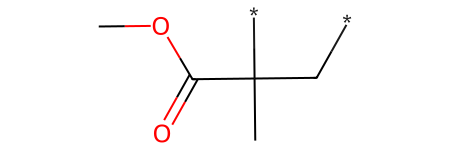

0 C has 3 explicit valence
1 C has 3 explicit valence
2 C has 1 explicit valence
3 C has 4 explicit valence
4 O has 2 explicit valence
5 O has 2 explicit valence
6 C has 1 explicit valence
[CH2][C](C)(C(=O)OC)  explicit_smiles


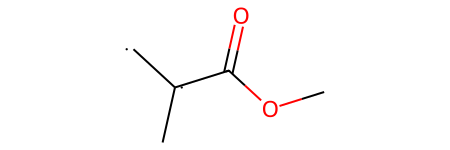

0 C has 1 explicit valence
1 C has 3 explicit valence
2 C has 1 explicit valence
3 C has 4 explicit valence
4 O has 2 explicit valence
5 O has 2 explicit valence
6 C has 1 explicit valence
CC(C)(C(=O)OC)  stripped_PSMILES


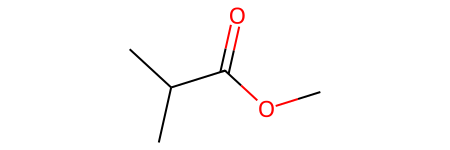

In [37]:
# trying to parse PSMILES to explicit SMILES
from rdkit import Chem
PSMILES = "[*]CC([*])(C)(C(=O)OC)"
explicit_smiles = "[CH2][C](C)(C(=O)OC)"
# stripped_PSMILES = PSMILES.replace("[*]", "")
stripped_PSMILES = "CC(C)(C(=O)OC)"


PSMILES_mol = Chem.MolFromSmiles(PSMILES)
explicit_smiles_mol = Chem.MolFromSmiles(explicit_smiles)
stripped_PSMILES_mol = Chem.MolFromSmiles(stripped_PSMILES)

for atom in PSMILES_mol.GetAtoms():
    print(str(atom.GetIdx()) +" "+ atom.GetSymbol() + " has " + str(atom.GetExplicitValence()) + " explicit valence")
print(PSMILES, " PSMILES")
display(PSMILES_mol)

for atom in explicit_smiles_mol.GetAtoms():
    print(str(atom.GetIdx()) +" "+ atom.GetSymbol() + " has " + str(atom.GetExplicitValence()) + " explicit valence")
print(explicit_smiles, " explicit_smiles")
display(explicit_smiles_mol)

for atom in stripped_PSMILES_mol.GetAtoms():
    print(str(atom.GetIdx()) +" "+ atom.GetSymbol() + " has " + str(atom.GetExplicitValence()) + " explicit valence")
print(stripped_PSMILES, " stripped_PSMILES")
display(stripped_PSMILES_mol)

In [38]:
''' illegal codes
* C=C* -> *C=C*
*OC(CCC(c1ccccc1))CC(=O)O*
*C=CC(=O)OC#N*
*CC(=C)C#N*
CC(c1cc(Cl)cccc1)
'''

Chem.MolFromSmiles("S"+"CC(c1cc(Cl)cccc1)"*2+"S")

[09:51:02] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 9 10


In [39]:
import re
def parse_p_to_explicit_smiles(psmiles: str) -> str:
    # first create a mol object
    # print(f"parsing {psmiles}")

    mol = Chem.MolFromSmiles(psmiles)
    if mol is None:
        print(f"{psmiles} is not a valid SMILES string")
        return ""


    # iterate over the atoms catching the position of the C Atoms following and preceding [*] and their valence
    star_index = []
    valence = []
    atomsymbols = []
    for atom in mol.GetAtoms():
        atomsymbol = atom.GetSymbol()
        if atom.GetIsAromatic():
            atomsymbol = atomsymbol.lower()
        atomsymbols.append(atomsymbol)
        if atomsymbol == "*":
            star_index.append(atom.GetIdx())
        valence.append(atom.GetExplicitValence())
    c_index = [star_index[0]+1, star_index[1]-1] # cannot do that atom symbols are not in order

    if len(star_index) > 2:
        # raise a type error
        raise TypeError ("{__name__} cannot handle ladder polymers/more than two [*] in the PSMILES string!")
    # the current valence of the C atoms is the explicit minus the [*] connection/-1
    def valence_change(val):
        return 4 - val
    h_num = []
    for sy, val in zip(atomsymbols, valence):  # number of H atoms assuming C atoms
        if sy == "C":
            h_num.append(valence_change(val))
        else:
            h_num.append(0)

    # replace C atoms with the explicit hydrogen count and catch the special case of parenthesised like e.g.([*]) and parenthesise the dangling part of the smiles string to the end after that C atom like [*]CC([*])(C)C(=O)OC -> [CH2][C](C)(C(=O)OC) (attention to the bracket pair ending with the last symbol ")")

    atomsymbols = [_atom if _atom != "*" else r"\*" for _atom in atomsymbols] # escape the * for the regex

    # create a dict of atom index and index of it's symbol in the string
    atom_positions = [m.start() for m in re.finditer(r"("+'|'.join(atomsymbols)+")", psmiles)]


    atom_string_map = {atom_symbol_nr:string_pos for atom_symbol_nr, string_pos in zip(range(len(atomsymbols)), atom_positions)}
    c_str_indexes = [atom_string_map[_c_index] for _c_index in c_index]

    c_str_h_num = {atom_string_map[_c_index]:h_num[_c_index] for _c_index in c_index}

    smiles_reconstruction = ""
    for idx, character in enumerate(psmiles):
        if idx in c_str_indexes:
            smiles_reconstruction += f"[CH{c_str_h_num[idx]}]" if c_str_h_num[idx] > 0 else f"[{character}]"
        else:
            smiles_reconstruction += character


    smiles_reconstruction = smiles_reconstruction.replace("([*])", "")
    smiles_reconstruction = smiles_reconstruction.replace("[*]", "")
    smiles_reconstruction = smiles_reconstruction.replace("*", "")

    return smiles_reconstruction
for test_PSMILE in ["*C(=O)CC(CCC)O*", "[*]CC([*])(C)(C(=O)OC)", "*OC(CCC(c1ccccc1))CC(=O)O*",]:
# for test_PSMILE in ["*OC(CCC(c1ccccc1))CC(=O)O*", "*C(=O)CC(CCC)O*", "[*]CC([*])(C)(C(=O)OC)", ]:
    print(test_PSMILE + " parsing...")
    print(parse_p_to_explicit_smiles(test_PSMILE))


*C(=O)CC(CCC)O* parsing...
[C](=O)CC(CCC)[O]
[*]CC([*])(C)(C(=O)OC) parsing...
[CH2][C](C)(C(=O)OC)
*OC(CCC(c1ccccc1))CC(=O)O* parsing...
[O]C(CCC(c1ccccc1))CC(=O)[O]


In [40]:
# create three 2D permutation tables (for each solvent)
# I want to create the three tables with same headers (on first row and first column) and then fill them by iterating through the table and the discarded table to show which where tried, which "worked", which did not and where thus discarded and which are not tried. 

# Since there are less agents than monomers prior will be the filling the first row
same_row_headers = [str(x) for x in range(1,17)] # just the index
same_column_headers = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"] 
DMF_p_table = pd.DataFrame(data=np.zeros((16, 10), dtype=int), columns=same_column_headers, index=same_row_headers)
Tol_p_table = pd.DataFrame(data=np.zeros((16, 10), dtype=int), columns=same_column_headers, index=same_row_headers)
DMSO_p_table = pd.DataFrame(data=np.zeros((16, 10), dtype=int), columns=same_column_headers, index=same_row_headers)

# fill the tables
def fill_dataset_into_tables(dataset: pd.DataFrame, fill: int):
    for row in dataset.itertuples():
        monomer = row.monomer
        agent = row._4 # since the - of RAFT-Agent is not allowed as an attribute name
        solvent = row.solvent
        match solvent:
            case "DMF":
                DMF_p_table.loc[monomer, agent] += fill
            case "Tol":
                Tol_p_table.loc[monomer, agent] += fill
            case "DMSO":
                DMSO_p_table.loc[monomer, agent] += fill

fill_dataset_into_tables(sRt.df, 10)
fill_dataset_into_tables(sRt.discarded_df, -1)
# fill_dataset_into_tables(sRt.permutations_df, -3)
# looking at e.g "4" "A" as monomer['4-Methylstyrene' raft_agent '2-Cyan-2-propylbenzodithioat' 4 experiments were introduced but 3 were discarded
# a reaction that worked once will now just be set as "working whilst 
def value_format(val):
    if val > 0:
        return True
    elif val == 0:
        return np.nan
    else:
        return False

DMSO_p_table = DMSO_p_table.map(value_format)
Tol_p_table = Tol_p_table.map(value_format)
DMF_p_table = DMF_p_table.map(value_format)

In [42]:
# write permutation tables to file
# with pd.ExcelWriter(os.path.join(os.getcwd(), "data", "data exploration figures", "permutation tables.xlsx")) as writer:
#     DMSO_p_table.to_excel(writer, sheet_name="DMSO", index=True)
#     Tol_p_table.to_excel(writer, sheet_name="Toluene", index=True)
#     DMF_p_table.to_excel(writer, sheet_name="DMF", index=True)

In [50]:
# re-involve the abortive experiments with a score of 0
# 1st get the experiments from the discarded_df
# 2nd count those nunique and bring them in the same shape as the kinetics_df 
#   translate monomer and agent numbers and letters
#   leave conversion, time, score and so forth 0
# 3rd append them to the kinetics_df
reformatted_discarded = sRt.discarded_df[["Experiment number", "monomer", "RAFT-Agent", "solvent"]].copy()
# rename and reorder columns
reformatted_discarded.columns = ["exp_nr", "monomer", "RAFT-Agent", "solvent"]
mappables = ["monomer", "RAFT-Agent", "solvent"]
reformatted_discarded[mappables] = reformatted_discarded[mappables].map(lambda x: reaction_descriptors_dict[x])

reformatted_discarded["score"] = 0

,exp_nr,monomer,RAFT-Agent,solvent
0,99,Lauryl methacrylate,2-Phenyl-2-propyl benzodithioate,Toluene
1,166,Methyl acrylate,4-Cyano-4-(phenylcarbonothioylthio)pentanoic acid,Dimethylformamide
2,167,Methyl acrylate,4-Cyano-4-(phenylcarbonothioylthio)pentanoic acid,Dimethylsulfoxide
3,168,Methyl acrylate,4-Cyano-4-(phenylcarbonothioylthio)pentanoic acid,Toluene
4,169,Butyl acrylate,4-Cyano-4-(phenylcarbonothioylthio)pentanoic acid,Dimethylformamide
...,...,...,...,...
306,402,(2-Dimethylaminoethyl)methacrylate,Benzyl 1H-pyrrole-1-carbodithioate,Toluene
307,402,(2-Dimethylaminoethyl)methacrylate,Benzyl 1H-pyrrole-1-carbodithioate,Toluene
308,403,Benzyl methacrylate,Benzyl 1H-pyrrole-1-carbodithioate,Dimethylformamide
309,403,Benzyl methacrylate,Benzyl 1H-pyrrole-1-carbodithioate,Dimethylformamide


In [46]:
kinetics_df

,exp_nr,max_con,theo_max_con,theo_react_end,monomer,RAFT-Agent,solvent,fit_p1,fit_p2,p1_variance,p1_p2_covariance,p2_variance,squared_error,conv_time_data,Mn_time_data,Mw_time_data,error_score,score
0,16,0.516574,0.687652,30.000000,Methyl methacrylate,2-Cyan-2-propylbenzodithioat,Dimethylformamide,0.776540,0.072249,1.161555e-06,1.708620e-07,2.003401e-18,0.025624,"[[0.0, 2.011111111111111, 4.018055555555556, 8...","[[1.0055555555555555, 2.011111111111111, 4.018...","[[1.0055555555555555, 2.011111111111111, 4.018...",2,1.937343
1,17,0.697321,0.733482,17.964494,Methyl methacrylate,2-Cyan-2-propylbenzodithioat,Dimethylsulfoxide,0.814980,0.128174,2.270924e-08,6.921795e-09,1.846966e-19,0.003503,"[[0.0, 2.011111111111111, 4.018055555555556, 8...","[[1.0055555555555555, 2.011111111111111, 4.018...","[[1.0055555555555555, 2.011111111111111, 6.008...",0,2.167049
2,18,0.323281,0.538534,30.000000,Methyl methacrylate,2-Cyan-2-propylbenzodithioat,Toluene,1.000000,0.025778,1.729876e-06,5.503522e-08,1.354209e-19,0.000551,"[[0.0, 4.0777777777777775, 8.090277777777779, ...","[[1.073611111111111, 2.0680555555555555, 4.077...","[[1.073611111111111, 2.0680555555555555, 4.077...",1,1.792611
3,19,0.565125,0.795232,30.000000,Butyl methacrylate,2-Cyan-2-propylbenzodithioat,Dimethylformamide,0.953088,0.059934,3.770059e-06,3.520726e-07,2.592729e-18,0.049599,"[[0.0, 1.073611111111111, 2.0680555555555555, ...","[[1.073611111111111, 2.0680555555555555, 4.077...","[[1.073611111111111, 2.0680555555555555, 4.077...",3,2.030151
4,21,0.328939,0.530259,30.000000,Butyl methacrylate,2-Cyan-2-propylbenzodithioat,Toluene,1.000000,0.025186,3.123627e-04,9.644457e-06,2.303885e-17,0.149107,"[[0.0, 1.1319444444444444, 2.125, 4.1430555555...","[[1.1319444444444444, 2.125, 4.143055555555556...","[[1.1319444444444444, 2.125, 4.143055555555556...",8,1.490601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,516,0.495575,0.576148,23.541856,Butyl methacrylate,2-(Dodecylthiocarbonothioylthio)-2-methylpropi...,Toluene,0.640165,0.097808,1.041329e-07,2.809498e-08,6.267405e-19,0.007012,"[[0.0, 2.125, 4.143055555555556, 8.18055555555...","[[1.1319444444444444, 2.125, 4.143055555555556...","[[1.1319444444444444, 2.125, 4.143055555555556...",0,1.934658
237,519,0.721212,0.803002,21.397242,Lauryl methacrylate,2-(Dodecylthiocarbonothioylthio)-2-methylpropi...,Toluene,0.892225,0.107611,1.499523e-08,3.449303e-09,6.615314e-20,0.001022,"[[0.0, 4.273611111111111, 8.338888888888889, 1...","[[1.2513888888888889, 2.2416666666666667, 4.27...","[[1.2513888888888889, 2.2416666666666667, 4.27...",0,2.225593
238,522,0.360000,0.344913,11.648310,(2-Dimethylaminoethyl)methacrylate,2-(Dodecylthiocarbonothioylthio)-2-methylpropi...,Toluene,0.383237,0.197675,2.308136e-07,2.498172e-07,2.877692e-17,0.140703,"[[0.0, 1.3125, 2.301388888888889, 4.3361111111...","[[1.3125, 2.301388888888889, 4.336111111111111...","[[1.3125, 2.301388888888889, 4.336111111111111...",5,1.501869
239,523,0.840426,0.836045,14.901526,Benzyl methacrylate,2-(Dodecylthiocarbonothioylthio)-2-methylpropi...,Dimethylformamide,0.928939,0.154520,5.701286e-07,1.901712e-07,6.023358e-18,0.197665,"[[0.0, 1.3736111111111111, 2.3694444444444445,...","[[1.3736111111111111, 2.3694444444444445, 4.40...","[[1.3736111111111111, 2.3694444444444445, 4.40...",5,2.012342
